In [4]:
import numpy as np
import pandas as pd  
from numpy import newaxis
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as seabornInstance 
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split,ShuffleSplit,learning_curve
from sklearn.metrics import r2_score,mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from keras import backend as K
from sklearn import metrics


algorithmName = []
trainingAccList = []
testingAccList = []
mseList = []
RMSE=[]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import numpy as np
T=10
n_sim=10000
buyout=100
buy_year=5
r=0.05#risk free risk
price_0=25#oil price
price_sigma=0.15
opex_0=10.2
opex_sigma=0.1
quant=np.array([9, 7.7, 6.5, 5.5, 4.7, 4, 3.4, 2.9, 2.5, 2.1])
capex=5
rng = np.random.RandomState(1)


# price matrix and opex matrix
price = np.c_[np.ones((n_sim, 1))*price_0, np.empty([n_sim, T - 1])]
opex = np.c_[np.ones((n_sim, 1))*opex_0, np.empty([n_sim, T - 1])]

# simulate prices (GBM) and opex 
for t in np.arange(1,T):
    price[:, t] = price[:, t - 1] * np.exp(-0.5*(price_sigma**2)*1 + 
                                           price_sigma*rng.randn(n_sim).T)
    
    opex[:, t] = opex[:, t - 1] * np.exp(0.02-0.5*((opex_sigma)**2)*1 +
                                            opex_sigma*rng.randn(n_sim).T)


rev_gross = quant*price
cost = quant*opex
rev_net = rev_gross-cost-capex
net_cf = rev_net * 3/4
dis_fact = np.array([(1 + r)**(-i - 1) for i in range(T)])

# net present value of cash flows
npv = (net_cf * dis_fact).sum(axis=1)

# net present value of cash flows in years 6-10
npv_cont = (net_cf[:, buy_year:] * dis_fact[buy_year:]).sum(axis=1)

# put together regressor matrix with price and opex in buyout year
X_price = price[:, buy_year]
X_opex = opex[:, buy_year]
X = np.c_[X_price, X_opex]

In [6]:
Y = npv_cont[..., newaxis]

train_X = X[500:]
test_X = X[:500]
train_Y = Y[500:]
test_Y = Y[:500]

print("Traing data size: ", train_X.shape)
print("Testing data size: ", test_X.shape)

algorithmName = []
trainingAccList = []
testingAccList = []
mseList = []

Traing data size:  (9500, 2)
Testing data size:  (500, 2)


In [7]:
# define model I am using for regression
lr = LinearRegression()

# training process
lr.fit(train_X, train_Y)

algorithmName.append("LR")

In [8]:
cv_pred_lr = lr.predict(test_X)

mse = mean_squared_error(test_Y, cv_pred_lr)
mseList.append(mse)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 822.16
RMSE: 28.67


In [9]:
# define model I am using for regression
SVR = svm.SVR(kernel='rbf', degree=3)

# training process
SVR.fit(train_X, train_Y)

algorithmName.append("SVR")

In [10]:
cv_pred_SVR = SVR.predict(test_X)

mse = mean_squared_error(test_Y, cv_pred_SVR)
mseList.append(mse)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 1084.76
RMSE: 32.94


In [11]:
max_val = []
results=[]
for i in cv_pred_SVR:
    if i<100:
        max_val.append(100)
    elif 100<i<120:
        max_val.append(i)
    else:
        max_val.append(i-40+(i/3-40))
# expected NPV with option

enpv_w_opt = ((net_cf[:, :buy_year] * dis_fact[:buy_year]).sum(axis=1)).mean(axis=0) + np.mean(max_val,axis=0)+capex
# expected NPV without the option
enpv_wo_opt = npv.mean(axis=0) 
opt_val = enpv_w_opt - enpv_wo_opt

print ("The ENPV of the project without the option is $%.1f" % enpv_wo_opt)
print ("The ENPV of the project with the option is $%.1f" % enpv_w_opt)
print ("The value of the option to sell in year %s is $%.1f" % (buy_year, opt_val))

The ENPV of the project without the option is $390.7
The ENPV of the project with the option is $417.7
The value of the option to sell in year 5 is $27.0


In [12]:
# define model I am using for regression
rf = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)

# training process
rf.fit(train_X, train_Y)

algorithmName.append("RF")

In [13]:
cv_pred_rf = rf.predict(test_X)

mse = mean_squared_error(test_Y, cv_pred_rf)
mseList.append(mse)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 956.67
RMSE: 30.93


In [14]:
# define model I am using for regression
lasso = LassoCV()

# training process
lasso.fit(train_X, train_Y)

algorithmName.append("Lasso")

In [15]:
cv_pred_lasso = lasso.predict(test_X)

mse = mean_squared_error(test_Y, cv_pred_lasso)
mseList.append(mse)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 822.08
RMSE: 28.67


In [16]:
# define model I am using for regression
ridge = RidgeCV()

# training process
ridge.fit(train_X, train_Y)

algorithmName.append("Ridge")

In [17]:
cv_pred_ridge = ridge.predict(test_X)

mse = mean_squared_error(test_Y, cv_pred_ridge)
mseList.append(mse)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 822.16
RMSE: 28.67


In [18]:
# MLP regressor, one layer, more neurons
model = MLPRegressor(hidden_layer_sizes=(128, ), activation='relu', solver='adam',batch_size='auto',validation_fraction=0.1, \
                     random_state=1, max_iter=500)
model.fit(train_X, train_Y)
algorithmName.append("DNN")

In [19]:
cv_pred_dnn = model.predict(test_X)
mse = mean_squared_error(test_Y, cv_pred_dnn)
mseList.append(mse)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 827.88
RMSE: 28.77


In [20]:
import lightgbm as ltb
D = ltb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.09, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=20)
D.fit(train_X, train_Y) 
algorithmName.append("LGBM") 
score_lr_D = D.score(train_X, train_Y)  
print("Training score: ", score_lr_D*100,"%")
trainingAccList.append(score_lr_D)

print("Testing score: ", D.score(test_X, test_Y)*100,"%")
testingAccList.append(D.score(test_X, test_Y))
cv_pred_lr_D = D.predict(test_X)

mse = mean_squared_error(test_Y, cv_pred_lr_D)
mseList.append(mse)
RMSE.append(np.sqrt(metrics.mean_squared_error(test_Y, cv_pred_lr_D)))
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(test_Y, cv_pred_lr_D)))

Training score:  77.1925451887981 %
Testing score:  76.52689575166536 %
MSE: 1291.77
RMSE: 35.94


In [21]:
max_val = []
results=[]
for i in cv_pred_lr_D:
    if i<100:
        max_val.append(100)
    elif 100<i<120:
        max_val.append(i)
    else:
        max_val.append(i-40+(i/3-40))
# expected NPV with option

enpv_w_opt = ((net_cf[:, :buy_year] * dis_fact[:buy_year]).sum(axis=1)).mean(axis=0) + np.mean(max_val,axis=0)+capex
# expected NPV without the option
enpv_wo_opt = npv.mean(axis=0) 
opt_val = enpv_w_opt - enpv_wo_opt

print ("The ENPV of the project without the option is $%.1f" % enpv_wo_opt)
print ("The ENPV of the project with the option is $%.1f" % enpv_w_opt)
print ("The value of the option to sell in year %s is $%.1f" % (buy_year, opt_val))

The ENPV of the project without the option is $390.7
The ENPV of the project with the option is $419.9
The value of the option to sell in year 5 is $29.3


In [22]:
import xgboost as xgb
D = xgb.XGBRegressor()
D.fit(train_X, train_Y)

score_lr_D = D.score(train_X, train_Y)  
print("Training score: ", score_lr_D*100,"%")
trainingAccList.append(score_lr_D)

print("Testing score: ", D.score(test_X, test_Y)*100,"%")
testingAccList.append(D.score(test_X, test_Y))
cv_pred_lr_D = D.predict(test_X)
algorithmName.append("xgboost")
mse = mean_squared_error(test_Y, cv_pred_lr_D)
mseList.append(mse)
RMSE.append(np.sqrt(metrics.mean_squared_error(test_Y, cv_pred_lr_D)))
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(test_Y, cv_pred_lr_D)))

[23:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training score:  85.87055727005021 %
Testing score:  84.7083482790393 %
MSE: 841.53
RMSE: 29.01


In [23]:
from sklearn.ensemble import GradientBoostingRegressor
D = GradientBoostingRegressor(random_state=0)
# training process
D.fit(train_X, train_Y)
algorithmName.append("GB")
score_lr_D = D.score(train_X, train_Y)  
print("Training score: ", score_lr_D*100,"%")
trainingAccList.append(score_lr_D)

print("Testing score: ", D.score(test_X, test_Y)*100,"%")
testingAccList.append(D.score(test_X, test_Y))
cv_pred_lr_D = D.predict(test_X)
mse = mean_squared_error(test_Y, cv_pred_lr_D)
mseList.append(mse)
RMSE.append(np.sqrt(metrics.mean_squared_error(test_Y, cv_pred_lr_D)))
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(test_Y, cv_pred_lr_D)))

Training score:  85.96848919120725 %
Testing score:  84.65982368271567 %
MSE: 844.20
RMSE: 29.06


In [24]:
len(mseList)

9

In [25]:
len(algorithmName)

9

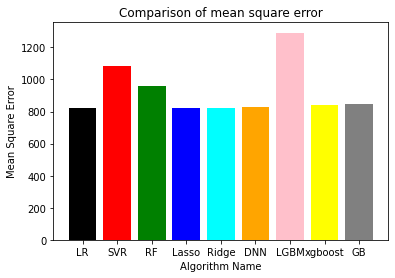

In [26]:
y_pos = np.arange(len(algorithmName))
plt.bar(y_pos, mseList, color=['black', 'red', 'green', 'blue', 'cyan', 'orange','pink','yellow','grey'])
plt.xticks(y_pos, algorithmName)
plt.title("Comparison of mean square error")
plt.xlabel("Algorithm Name")
plt.ylabel("Mean Square Error")
plt.show()